In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import numpy as np
from blimpy import read_header, Waterfall, Filterbank

import sys, os, glob
import csv

sys.path.append("../../../setigen/")
import setigen as stg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tsamp = 1.4316557653333333
fch1 = 3751.464843051508
df = -1.3969838619232178e-06

fchans = 1024
tchans = 32
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

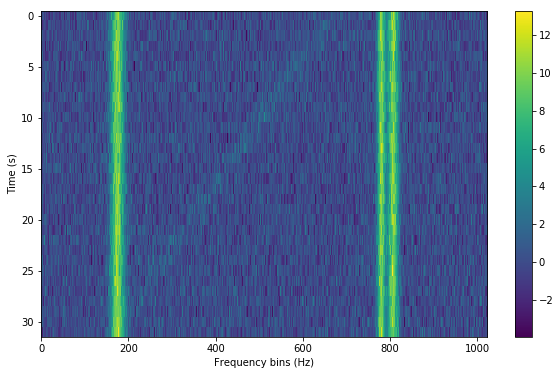

In [177]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans), (fchans-1-start_index)*df/(tsamp*tchans))
line_width = np.random.uniform(0.02, 0.03) ** 3
level = 1

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

for i in range(3):
    start_index = np.random.randint(0,fchans)
    drift_rate = 0
    line_width = np.random.uniform(0.02, 0.03) ** 3
    level = 10

    signal0 = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                          stg.constant_t_profile(level = level),
                          stg.gaussian_f_profile(width = line_width),
                          stg.constant_bp_profile(level = 1.0),
                          integrate = True)

    signal += signal0
    

signal = stg.inject_noise(signal)

fig = plt.figure(figsize=(10,6))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins (Hz)')
plt.ylabel('Time (s)')
plt.show()

In [4]:
def generate_signal(sig_type='constant',
                    line_width=0.02**3,
                    level=10,
                    bias_no_drift=0,
                    **kwargs):
    # bias no drift is fraction of the time drift rate should be set to 0
    start_index = np.random.randint(0, fchans)
    if np.random.uniform(0, 1) < bias_no_drift:
        drift_rate = 0
    else:
        drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                                   (fchans-1-start_index)*df/(tsamp*tchans))
    
    if sig_type == 'noise':
        signal = stg.generate(ts,
                              fs,
                              stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                              stg.constant_t_profile(level = 0),
                              stg.gaussian_f_profile(width = line_width),
                              stg.constant_bp_profile(level = 1.0),
                              integrate = False)
    elif sig_type == 'constant':
        signal = stg.generate(ts,
                              fs,
                              stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                              stg.constant_t_profile(level = level),
                              stg.gaussian_f_profile(width = line_width),
                              stg.constant_bp_profile(level = 1.0),
                              integrate = True)
    elif sig_type == 'simple_rfi':
        drift_rate = 0
        if 'spread' in kwargs.keys():
            spread = kwargs['spread']
        else:
            spread = np.random.uniform(0.0002, 0.0003)

        signal = stg.generate(ts,
                              fs,
                              stg.choppy_rfi_path(f_start = fs[start_index], drift_rate = drift_rate, spread=spread, spread_type='gaussian'),
                              stg.constant_t_profile(level = level),
                              stg.gaussian_f_profile(width = line_width),
                              stg.constant_bp_profile(level = 1.0),
                              integrate = True)
    elif sig_type == 'scintillated':
        period = kwargs['period'] # np.random.uniform(1,5)
        phase = kwargs['phase'] # np.random.uniform(0, period)
        sigma = kwargs['sigma'] # np.random.uniform(0.1, 2)
        pulse_dir = kwargs['pulse_dir'] #'rand'
        width = kwargs['width'] # np.random.uniform(0.1, 2)
        pnum = kwargs['pnum'] # 10
        amplitude = kwargs['amplitude'] # np.random.uniform(level*2/3, level)

        signal = stg.generate(ts,
                              fs,
                              stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                              stg.periodic_gaussian_t_profile(period, phase, sigma, pulse_dir, width, pnum, amplitude, level),
                              stg.gaussian_f_profile(width = line_width),
                              stg.constant_bp_profile(level = 1.0),
                              integrate = True)
    return signal

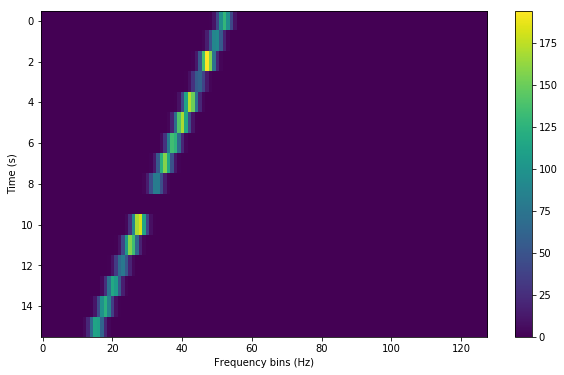

In [29]:
tsamp = 18.3
fch1 = 6000
df = -3e-06

fchans = 128
tchans = 16
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans), (fchans-1-start_index)*df/(tsamp*tchans))
# drift_rate = 0
line_width = 4e-6
level = 100

period = np.random.uniform(1,5)
phase = np.random.uniform(0,period)
sigma = np.random.uniform(0.1, 2)
pulse_dir = 'rand'
width = np.random.uniform(0.1, 10)
pnum = 10
amplitude = np.random.uniform(level*1/3, level)

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.periodic_gaussian_t_profile(period, phase, sigma, pulse_dir, width, pnum, amplitude, level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),)

# signal = stg.normalize(stg.inject_noise(signal), cols=32, exclude = 0.2, use_median=False)
# signal = stg.inject_noise(signal)

fig = plt.figure(figsize=(10,6))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins (Hz)')
plt.ylabel('Time (s)')

np.save('scint', signal)
plt.show()

# print(start_index, drift_rate, line_width)

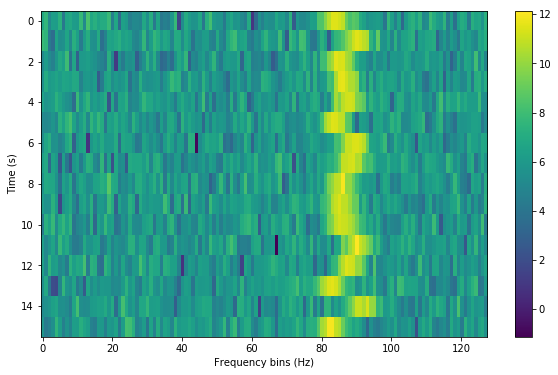

86 0 8e-06


In [224]:
tsamp = 18.3
fch1 = 6000
df = -3e-06

fchans = 128
tchans = 16
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

start_index = np.random.randint(0,fchans)
# drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans), (fchans-1-start_index)*df/(tsamp*tchans))
line_width = 8e-6
level = 10

drift_rate = 0
spread = 0.00004

signal = stg.generate(ts,
                      fs,
                      stg.choppy_rfi_path(f_start = fs[start_index], drift_rate = drift_rate, spread=spread, spread_type='gaussian'),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

# signal = stg.normalize(stg.inject_noise(signal), cols=32, exclude = 0.2, use_median=False)
signal = np.log10(stg.inject_noise(signal) + 4) * 10

fig = plt.figure(figsize=(10,6))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins (Hz)')
plt.ylabel('Time (s)')

np.save('rfi', signal)
plt.show()

print(start_index, drift_rate, line_width)

In [146]:
tsamp = 18.3
fch1 = 6000
df = 3.2

fchans = 128
tchans = 16
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

line_width = np.random.uniform(0.015, 0.03) ** 3
level = 2

period = np.random.uniform(1,5)
phase = np.random.uniform(0,period)
sigma = np.random.uniform(0.1, 2)
pulse_dir = 'rand'
width = np.random.uniform(0.1, 2)
pnum = 10
amplitude = np.random.uniform(level*2/3, level)

signal = generate_signal(sig_type='scintillated',
                        line_width=line_width,
                        level=level,
                        bias_no_drift=0.5,
                        period=period,
                        phase=phase,
                        sigma=sigma,
                        pulse_dir=pulse_dir,
                        width=width,
                        pnum=pnum,
                        amplitude=amplitude)

signal = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)

fig = plt.figure(figsize=(10,6))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins (Hz)')
plt.ylabel('Time (s)')

plt.show()

NameError: name 'generate_signal' is not defined

/home/bryanb/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (10) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


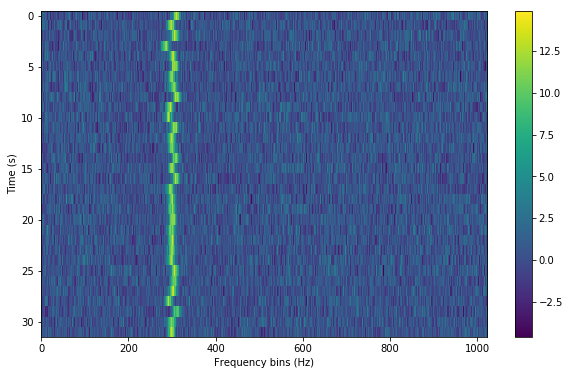

In [121]:
line_width = np.random.uniform(0.015, 0.03) ** 3
level = 10

spread = np.random.uniform(0.003, 0.017) ** 2
# spread = np.random.uniform(0.00001, 0.0003)

signal = generate_signal(sig_type='simple_rfi',
                        line_width=line_width,
                        level=level,
                         spread=spread,
                        bias_no_drift=0.5,)

signal = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)

fig = plt.figure(figsize=(10,6))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins (Hz)')
plt.ylabel('Time (s)')

plt.show()

[]

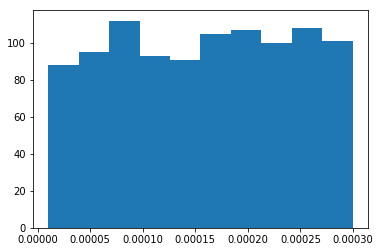

In [115]:
plt.hist(np.random.uniform(0.00001, 0.0003, 1000))
plt.plot()

[]

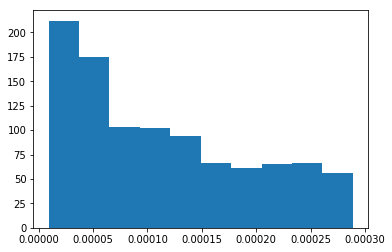

In [118]:
plt.hist(np.random.uniform(0.003, 0.017, 1000) ** 2)
plt.plot()

In [83]:
np.sqrt(0.0003)

0.017320508075688773

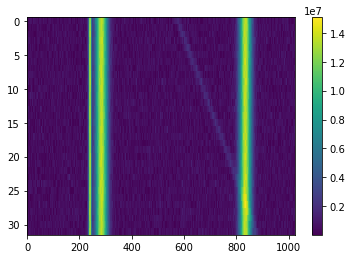

In [21]:
import numpy as np
frame = np.load('/datax/scratch/bbrzycki/training/training1/train/frame_3rfi_1sig_15db_0100.npy')
plt.imshow(frame, aspect='auto')
plt.colorbar()
plt.show()